# Sentiment Analysis Only to Predict Price

In [1]:
import string
import nltk
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.core.display import clear_output
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tag import pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.python.keras import models
from tensorflow.python.keras import layers

In [2]:
financial_kaggle = pd.read_csv('../data/financial_news.csv')
financial_kaggle

,Sentiment,Article
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [3]:
file = open("company_news.txt", "r")
lines = file.readlines()
print(len(lines))
lines[0]

309546


'MMM, Hot Stocks: XRX, MMM drop on results; ERIC, LOGI rally; BALY gets takeover bid, \xa0-\xa012 hours ago\n'

In [4]:
lines[11].split(",")

['MMM',
 ' Apple',
 ' Facebook',
 ' Fed Decision: 3 Things to Watch',
 ' \xa0-\xa0Jan 26',
 ' 2021\n']

In [5]:
new_lines = [x.split(",") for x in lines]
new_lines[0]

['MMM',
 ' Hot Stocks: XRX',
 ' MMM drop on results; ERIC',
 ' LOGI rally; BALY gets takeover bid',
 ' \xa0-\xa012 hours ago\n']

In [6]:
for i, x in enumerate(new_lines):
    if len(x) > 3:
        new_str = ""
        if 'hours ago' in x[len(x) - 1]:
            for j in range(1, len(x) - 1):
                new_str += x[j] + " "
            new_list = [x[0], new_str, x[len(x) - 1]]
        else:
            for j in range(1, len(x) - 2):
                new_str += x[j] + " "
            new_list =[x[0], new_str, x[len(x) - 2] + x[len(x) - 1]]
        new_lines[i] = new_list
    if i % 100000 == 0:
        print(i)

0
100000
200000
300000


In [7]:
new_lines[309545]

['ZTS',
 ' 4 Dependable Healthcare Stocks to Buy Hand Over Fist Right Now ',
 ' \xa0-\xa0Dec 01 2021\n']

In [8]:
articles = pd.DataFrame(new_lines, columns = ['Symbol', 'Title', 'Date'])
articles

,Symbol,Title,Date
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,- 12 hours ago\n
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,- 17 hours ago\n
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,- Jan 23 2022\n
3,MMM,Top 5 Things to Watch in Markets in The Week ...,- Jan 23 2022\n
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,- Dec 22 2021\n
...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,- Dec 10 2021\n
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,- Dec 08 2021\n
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,- Dec 07 2021\n
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,- Dec 07 2021\n


In [9]:
# fix dates in articles dataframe
articles['Date'] = articles['Date'].str.replace('-', '')
articles['Date'] = articles['Date'].str.strip()
for i in range(len(articles)):
    if 'ago' in articles.iloc[i]['Date']:
        x = i
        articles.iloc[i]['Date'] = 'Jan 25 2022'
    if i % 100000 == 0:
        print(i)
articles['Date'] = pd.to_datetime(articles['Date'], format = '%b %d %Y')
articles

0
100000
200000
300000


,Symbol,Title,Date
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22
...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07


In [10]:
articles.iloc[0]

Symbol                                                  MMM
Title      Hot Stocks: XRX  MMM drop on results; ERIC  L...
Date                                    2022-01-25 00:00:00
Name: 0, dtype: object

In [11]:
df = articles.copy()
stop_words = list(stopwords.words('english'))
df['title/no_stopwords'] = df.apply(lambda row: pos_tag(word_tokenize(row['Title'])), axis = 1)
financial_kaggle['title/no_stopwords'] = financial_kaggle.apply(lambda row: pos_tag(word_tokenize(row['Article'])), axis = 1)
df

,Symbol,Title,Date,title/no_stopwords
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25,"[(Hot, JJ), (Stocks, NNS), (:, :), (XRX, NN), ..."
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25,"[(3M, CD), (Gains, NNS), (as, IN), (Price, NNP..."
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23,"[(Asian, JJ), (Stocks, NNP), (Down, NNP), (as,..."
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23,"[(Top, JJ), (5, CD), (Things, NNS), (to, TO), ..."
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22,"[(U.S., NNP), (stocks, NNS), (higher, RBR), (a..."
...,...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10,"[($, $), (0.97, CD), (Earnings, NNP), (Per, NN..."
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08,"[(Zoetis, NN), (Raises, VBZ), (FY22, NNP), (Di..."
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07,"[(Zoetis, NNP), (announces, VBZ), ($, $), (3.5..."
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07,"[(Zoetis, NN), (declares, VBZ), ($, $), (0.325..."


In [12]:
financial_kaggle

,Sentiment,Article,title/no_stopwords
0,neutral,"According to Gran , the company has no plans t...","[(According, VBG), (to, TO), (Gran, NNP), (,, ..."
1,neutral,Technopolis plans to develop in stages an area...,"[(Technopolis, NNP), (plans, VBZ), (to, TO), (..."
2,negative,The international electronic industry company ...,"[(The, DT), (international, JJ), (electronic, ..."
3,positive,With the new production plant the company woul...,"[(With, IN), (the, DT), (new, JJ), (production..."
4,positive,According to the company 's updated strategy f...,"[(According, VBG), (to, TO), (the, DT), (compa..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[(LONDON, NNP), (MarketWatch, NNP), (--, :), (..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[(Rinkuskiai, NNP), ('s, POS), (beer, NN), (sa..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[(Operating, NN), (profit, NN), (fell, VBD), (..."
4844,negative,Net sales of the Paper segment decreased to EU...,"[(Net, JJ), (sales, NNS), (of, IN), (the, DT),..."


In [13]:
def lemmatize_sentence(tokens):
  lemmatizer = WordNetLemmatizer()
  sentence = []
  for word, tag in tokens:
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v' 
    else:
      pos = 'a'
    sentence.append(lemmatizer.lemmatize(word, pos))
  return sentence

In [14]:
df['title/no_stopwords'] = df.apply(lambda row: lemmatize_sentence(row['title/no_stopwords']), axis = 1)
financial_kaggle['title/no_stopwords'] = financial_kaggle.apply(lambda row: lemmatize_sentence(row['title/no_stopwords']), axis = 1)
df

,Symbol,Title,Date,title/no_stopwords
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25,"[Hot, Stocks, :, XRX, MMM, drop, on, result, ;..."
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25,"[3M, Gains, as, Price, Hikes, Cost, Measures, ..."
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23,"[Asian, Stocks, Down, as, Investors, Brace, fo..."
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23,"[Top, 5, Things, to, Watch, in, Markets, in, T..."
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22,"[U.S., stock, high, at, close, of, trade, ;, D..."
...,...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10,"[$, 0.97, Earnings, Per, Share, Expected, for,..."
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08,"[Zoetis, Raises, FY22, Dividend, By, 30, %, An..."
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07,"[Zoetis, announce, $, 3.5, billion, share, buy..."
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07,"[Zoetis, declare, $, 0.325, dividend, buyback,..."


In [15]:
financial_kaggle

,Sentiment,Article,title/no_stopwords
0,neutral,"According to Gran , the company has no plans t...","[According, to, Gran, ,, the, company, have, n..."
1,neutral,Technopolis plans to develop in stages an area...,"[Technopolis, plan, to, develop, in, stage, an..."
2,negative,The international electronic industry company ...,"[The, international, electronic, industry, com..."
3,positive,With the new production plant the company woul...,"[With, the, new, production, plant, the, compa..."
4,positive,According to the company 's updated strategy f...,"[According, to, the, company, 's, updated, str..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[LONDON, MarketWatch, --, Share, price, end, l..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[Rinkuskiai, 's, beer, sale, fell, by, 6.5, pe..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[Operating, profit, fell, to, EUR, 35.4, mn, f..."
4844,negative,Net sales of the Paper segment decreased to EU...,"[Net, sale, of, the, Paper, segment, decrease,..."


In [16]:
def remove_noise(reviews, stop_words = ()):

    cleaned_tokens = []

    for token in reviews:
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)


        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [17]:
df['title/no_stopwords'] = df.apply(lambda row: remove_noise(row['title/no_stopwords'], stop_words), axis = 1)
financial_kaggle['title/no_stopwords'] = financial_kaggle.apply(lambda row: remove_noise(row['title/no_stopwords'], stop_words), axis = 1)
df

,Symbol,Title,Date,title/no_stopwords
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25,"[hot, stocks, xrx, mmm, drop, result, eric, lo..."
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25,"[3m, gains, price, hikes, cost, measures, offs..."
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23,"[asian, stocks, investors, brace, hawkish, fed]"
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23,"[top, 5, things, watch, markets, week, ahead]"
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22,"[u.s., stock, high, close, trade, dow, jones, ..."
...,...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10,"[0.97, earnings, per, share, expected, zoetis,..."
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08,"[zoetis, raises, fy22, dividend, 30, announces..."
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07,"[zoetis, announce, 3.5, billion, share, buybac..."
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07,"[zoetis, declare, 0.325, dividend, buyback, plan]"


In [18]:
financial_kaggle

,Sentiment,Article,title/no_stopwords
0,neutral,"According to Gran , the company has no plans t...","[according, gran, company, plan, move, product..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plan, develop, stage, area, less..."
2,negative,The international electronic industry company ...,"[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,"[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,"[according, company, 's, updated, strategy, ye..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[london, marketwatch, --, share, price, end, l..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, 's, beer, sale, fell, 6.5, per, c..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[operating, profit, fell, eur, 35.4, mn, eur, ..."
4844,negative,Net sales of the Paper segment decreased to EU...,"[net, sale, paper, segment, decrease, eur, 221..."


In [19]:
df['title/clean'] = df.apply(lambda row: ' '.join(row['title/no_stopwords']), axis = 1)
financial_kaggle['title/clean'] = financial_kaggle.apply(lambda row: ' '.join(row['title/no_stopwords']), axis = 1)
df

,Symbol,Title,Date,title/no_stopwords,title/clean
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25,"[hot, stocks, xrx, mmm, drop, result, eric, lo...",hot stocks xrx mmm drop result eric logi rally...
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25,"[3m, gains, price, hikes, cost, measures, offs...",3m gains price hikes cost measures offset supp...
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23,"[asian, stocks, investors, brace, hawkish, fed]",asian stocks investors brace hawkish fed
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23,"[top, 5, things, watch, markets, week, ahead]",top 5 things watch markets week ahead
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22,"[u.s., stock, high, close, trade, dow, jones, ...",u.s. stock high close trade dow jones industri...
...,...,...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10,"[0.97, earnings, per, share, expected, zoetis,...",0.97 earnings per share expected zoetis inc. n...
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08,"[zoetis, raises, fy22, dividend, 30, announces...",zoetis raises fy22 dividend 30 announces new b...
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07,"[zoetis, announce, 3.5, billion, share, buybac...",zoetis announce 3.5 billion share buyback plan...
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07,"[zoetis, declare, 0.325, dividend, buyback, plan]",zoetis declare 0.325 dividend buyback plan


In [20]:
def titles_for_model(cleaned_title):
  for title in cleaned_title:
    yield dict([token, True] for token in title)
    
positive = titles_for_model(financial_kaggle[financial_kaggle['Sentiment'] == 'positive']['title/no_stopwords'])
negative = titles_for_model(financial_kaggle[financial_kaggle['Sentiment'] == 'negative']['title/no_stopwords'])
neutral = titles_for_model(financial_kaggle[financial_kaggle['Sentiment'] == 'neutral']['title/no_stopwords'])

In [21]:
positive_data = [(title, 'Positive') for title in positive]
negative_data = [(title, 'Negative') for title in negative]
neutral_data = [(title, 'Neutral') for title in neutral]
complete_data = positive_data + negative_data + neutral_data

In [22]:
random.shuffle(complete_data)
training = complete_data[:round(len(complete_data) * .80)]
testing = complete_data[round(len(complete_data) * .80):]

In [23]:
nbclassifier = NaiveBayesClassifier.train(training)
print("Accuracy is: ", classify.accuracy(nbclassifier, testing))

Accuracy is:  0.6253869969040248


In [24]:
sample = "Asian Stocks Down as Investors Brace for Hawkish Fed"
custom_tokens = remove_noise(word_tokenize(sample))
print(custom_tokens)
print(nbclassifier.classify(dict([token, True] for token in custom_tokens)))

['asian', 'stocks', 'down', 'as', 'investors', 'brace', 'for', 'hawkish', 'fed']
Positive


In [25]:
titles = df['title/no_stopwords'].to_list()
df['Sentiment'] = ''
for i, t in enumerate(titles):
    df.at[i, 'Sentiment'] = nbclassifier.classify(dict([token, True] for token in t))
df    

,Symbol,Title,Date,title/no_stopwords,title/clean,Sentiment
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25,"[hot, stocks, xrx, mmm, drop, result, eric, lo...",hot stocks xrx mmm drop result eric logi rally...,Negative
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25,"[3m, gains, price, hikes, cost, measures, offs...",3m gains price hikes cost measures offset supp...,Positive
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23,"[asian, stocks, investors, brace, hawkish, fed]",asian stocks investors brace hawkish fed,Positive
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23,"[top, 5, things, watch, markets, week, ahead]",top 5 things watch markets week ahead,Neutral
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22,"[u.s., stock, high, close, trade, dow, jones, ...",u.s. stock high close trade dow jones industri...,Neutral
...,...,...,...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10,"[0.97, earnings, per, share, expected, zoetis,...",0.97 earnings per share expected zoetis inc. n...,Positive
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08,"[zoetis, raises, fy22, dividend, 30, announces...",zoetis raises fy22 dividend 30 announces new b...,Neutral
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07,"[zoetis, announce, 3.5, billion, share, buybac...",zoetis announce 3.5 billion share buyback plan...,Positive
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07,"[zoetis, declare, 0.325, dividend, buyback, plan]",zoetis declare 0.325 dividend buyback plan,Neutral


In [26]:
def get_quarterly_dates(row):
    quarterly_dates = np.array(['03-31', '06-30', '09-30', '12-31'])
    current_date = str(row['Date'])
    year = current_date[:5]
    current_date = current_date[5:10]
    new_date = quarterly_dates[quarterly_dates >= current_date]
    new_date = min(new_date)
    return year + new_date

In [27]:
df['quarterlyDateEnding'] = df.apply(get_quarterly_dates, axis = 1)
df

,Symbol,Title,Date,title/no_stopwords,title/clean,Sentiment,quarterlyDateEnding
0,MMM,Hot Stocks: XRX MMM drop on results; ERIC L...,2022-01-25,"[hot, stocks, xrx, mmm, drop, result, eric, lo...",hot stocks xrx mmm drop result eric logi rally...,Negative,2022-03-31
1,MMM,3M Gains as Price Hikes Cost Measures Offset...,2022-01-25,"[3m, gains, price, hikes, cost, measures, offs...",3m gains price hikes cost measures offset supp...,Positive,2022-03-31
2,MMM,Asian Stocks Down as Investors Brace for Hawk...,2022-01-23,"[asian, stocks, investors, brace, hawkish, fed]",asian stocks investors brace hawkish fed,Positive,2022-03-31
3,MMM,Top 5 Things to Watch in Markets in The Week ...,2022-01-23,"[top, 5, things, watch, markets, week, ahead]",top 5 things watch markets week ahead,Neutral,2022-03-31
4,MMM,U.S. stocks higher at close of trade; Dow Jon...,2021-12-22,"[u.s., stock, high, close, trade, dow, jones, ...",u.s. stock high close trade dow jones industri...,Neutral,2021-12-31
...,...,...,...,...,...,...,...
309541,ZTS,$0.97 Earnings Per Share Expected for Zoetis ...,2021-12-10,"[0.97, earnings, per, share, expected, zoetis,...",0.97 earnings per share expected zoetis inc. n...,Positive,2021-12-31
309542,ZTS,Zoetis Raises FY22 Dividend By 30% Announces...,2021-12-08,"[zoetis, raises, fy22, dividend, 30, announces...",zoetis raises fy22 dividend 30 announces new b...,Neutral,2021-12-31
309543,ZTS,Zoetis announces $3.5 billion share buyback p...,2021-12-07,"[zoetis, announce, 3.5, billion, share, buybac...",zoetis announce 3.5 billion share buyback plan...,Positive,2021-12-31
309544,ZTS,Zoetis declares $0.325 dividend buyback plan,2021-12-07,"[zoetis, declare, 0.325, dividend, buyback, plan]",zoetis declare 0.325 dividend buyback plan,Neutral,2021-12-31


In [34]:
df.iloc[1]['title/clean']

'3m gains price hikes cost measures offset supply chain issues'

In [29]:
# groupby symbol and quarterlyDateEnding to combine title into one document
new_df = df.groupby(['Symbol', 'quarterlyDateEnding'])['title/clean'].apply(" ".join).reset_index()
new_df

,Symbol,quarterlyDateEnding,title/clean
0,A,2017-06-30,agilent expand partnership agendia develop can...
1,A,2017-09-30,fda approve agilent 's keytruda companion diag...
2,A,2018-03-31,agilent acquires luxcel biosciences premarket ...
3,A,2018-06-30,flustered champion ostapenko fall first french...
4,A,2018-09-30,agilent technologies earnings beat revenue inl...
...,...,...,...
7687,ZTS,2018-12-31,money 's good fund ’ good fund merck bolster a...
7688,ZTS,2019-06-30,u.s. healthcare stock shield political pressur...
7689,ZTS,2019-09-30,elanco become no.2 animal health 7.6 billion b...
7690,ZTS,2021-12-31,zoetis inc. nyse zts shares sold retirement sy...


In [30]:
vectorizer = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit_transform(new_df['title/clean'].tolist())
tfidf = tfidf.toarray()
tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
tfidf_pd = pd.DataFrame(tfidf)
tfidf_pd['Symbol'] = new_df['Symbol']
tfidf_pd['quarterlyDateEnding'] = new_df['quarterlyDateEnding']
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,Symbol,quarterlyDateEnding
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-06-30
1,0.0,0.0,0.0,0.0,0.0,0.234200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-09-30
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-03-31
3,0.0,0.0,0.0,0.0,0.0,0.525255,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-06-30
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-12-31
7688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-06-30
7689,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-09-30
7690,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2021-12-31


In [32]:
prices = pd.read_csv("../data/monthly_prices.csv")
prices.columns = ['Date', 'open', 'high', 'low', 'close', 'volume', 'Symbol']
prices

,Date,open,high,low,close,volume,Symbol
0,2022-01-21,178.32,181.780,172.5600,172.65,34039389,MMM
1,2021-12-31,172.55,179.180,169.1801,177.63,48251474,MMM
2,2021-11-30,178.53,186.300,169.9400,170.04,47872133,MMM
3,2021-10-29,176.25,183.820,173.7800,178.68,48241875,MMM
4,2021-09-30,194.55,195.606,175.3700,175.42,67366254,MMM
...,...,...,...,...,...,...,...
118000,2013-07-31,31.02,31.650,28.9700,29.81,157249700,ZTS
118001,2013-06-28,32.01,32.990,29.4000,30.89,292403400,ZTS
118002,2013-05-31,32.97,34.280,31.7500,32.00,72809400,ZTS
118003,2013-04-30,33.42,34.740,30.4200,33.02,42045100,ZTS


In [33]:
# add prices to new_tfidf
new_tfidf = tfidf_pd.copy()
new_tfidf['Price'] = np.nan
for i in new_tfidf.index:
    symbol = new_tfidf.loc[i]['Symbol']
    #print(symbol)
    date = new_tfidf.loc[i]['quarterlyDateEnding']
    year_month = date[:7]
    tmp = prices[prices['Symbol'] == symbol]
    new_tmp = tmp[tmp['Date'].str.contains(year_month)]
    #print(tmp['Date'].str.contains(year_month) == True)
    #print(len(new_tmp))
    if len(new_tmp) == 0:
        continue
    new_tfidf.at[i, 'Price'] = new_tmp.iloc[0]['close']
new_tfidf

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-06-30,59.31
1,0.0,0.0,0.0,0.0,0.0,0.234200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-09-30,64.20
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-03-31,66.90
3,0.0,0.0,0.0,0.0,0.0,0.525255,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-06-30,61.84
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-09-30,70.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-12-31,85.54
7688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-06-30,113.49
7689,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-09-30,124.59
7690,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2021-12-31,244.03


In [115]:
nona_tfidf = new_tfidf.dropna()
nona_tfidf

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-06-30,59.31
1,0.0,0.0,0.0,0.0,0.0,0.234200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-09-30,64.20
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-03-31,66.90
3,0.0,0.0,0.0,0.0,0.0,0.525255,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-06-30,61.84
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-09-30,70.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-09-30,91.56
7687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-12-31,85.54
7688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-06-30,113.49
7689,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-09-30,124.59


In [126]:
# add previous quarter prices to df
nona_tfidf['prevPrice'] = np.nan
d = {'-03' : '-12', '-06' : '-03', '-09' : '-06', '-12' : '-09'}
for i in nona_tfidf.index:
    symbol = new_tfidf.loc[i]['Symbol']
    #print(symbol)
    date = new_tfidf.loc[i]['quarterlyDateEnding']
    year_month = date[:7]
    month = date[4:7]
    year = date[:4]
    tmp = prices[prices['Symbol'] == symbol]
    new_tmp = tmp[tmp['Date'].str.contains(year + d[month])]
    if len(new_tmp) == 0:
        continue
    nona_tfidf.at[i, 'prevPrice'] = new_tmp.iloc[0]['close']
nona_tfidf = nona_tfidf.dropna()
nona_tfidf

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_8702/567317927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nona_tfidf['prevPrice'] = np.nan


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price,prevPrice
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-06-30,59.31,52.87
1,0.0,0.0,0.0,0.0,0.0,0.234200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-09-30,64.20,59.31
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-03-31,66.90,67.46
3,0.0,0.0,0.0,0.0,0.0,0.525255,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-06-30,61.84,66.90
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-09-30,70.54,61.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-09-30,91.56,85.19
7687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-12-31,85.54,91.56
7688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-06-30,113.49,100.67
7689,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-09-30,124.59,113.49


In [141]:
nona_tfidf.to_csv("tfidf_vector.csv", index = False)

In [ ]:
# put all stories for a quarter into one document then get tfidf vector
# first neural network with just tfidf vectors to predict price change
# next try to combine sentiment analysis with historical data to predict price change

In [128]:
date_split = '2018-09-30'
X_train = nona_tfidf[nona_tfidf['quarterlyDateEnding'] < date_split].drop(['quarterlyDateEnding', 'Symbol', 'Price'], axis = 1)
y_train = nona_tfidf[nona_tfidf['quarterlyDateEnding'] < date_split]['Price']
X_test = nona_tfidf[nona_tfidf['quarterlyDateEnding'] >= date_split].drop(['quarterlyDateEnding', 'Symbol', 'Price'], axis = 1)
y_test = nona_tfidf[nona_tfidf['quarterlyDateEnding'] >= date_split]['Price']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
31/31 [==============================] - 1s 1ms/step - loss: 31256.2070 - mean_absolute_error: 105.9710
Epoch 2/10
31/31 [==============================] - 0s 1ms/step - loss: 29811.2441 - mean_absolute_error: 103.3168
Epoch 3/10
31/31 [==============================] - 0s 1ms/step - loss: 24778.7637 - mean_absolute_error: 93.6748
Epoch 4/10
31/31 [==============================] - 0s 1ms/step - loss: 13120.3809 - mean_absolute_error: 65.3052
Epoch 5/10
31/31 [==============================] - 0s 1ms/step - loss: 1859.2390 - mean_absolute_error: 20.1149
Epoch 6/10
31/31 [==============================] - 0s 1ms/step - loss: 853.2629 - mean_absolute_error: 13.4632
Epoch 7/10
31/31 [==============================] - 0s 1ms/step - loss: 807.8859 - mean_absolute_error: 12.5749
Epoch 8/10
31/31 [==============================] - 0s 1ms/step - loss: 808.0417 - mean_absolute_error: 12.5748
Epoch 9/10
31/31 [==============================] - 0s 1ms/step - loss: 808.4838 - mean_absol

In [129]:
# get MAE of neural network
model.evaluate(X_test, y_test)

131/131 [==============================] - 8s 1ms/step - loss: 3918.7451 - mean_absolute_error: 24.0860


[3918.7451171875, 24.086036682128906]

In [130]:
model.predict(X_test)

array([[ 63.94056 ],
       [ 73.87931 ],
       [ 78.762985],
       ...,
       [101.95919 ],
       [115.57276 ],
       [195.69461 ]], dtype=float32)

In [133]:
# invest 10000 evenly across top projected companies equally
init_investment = 10000
dates = nona_tfidf.loc[X_test.index]['quarterlyDateEnding'].unique()
dates.sort()
n = 10
i = 0
nShort = 1
portfolio = pd.DataFrame({})

for d in dates:
    # get top N price change predicted for a given quarter
    predicted_data = nona_tfidf.loc[X_test.index]
    predicted_data = predicted_data[predicted_data['quarterlyDateEnding'] == d]
    predicted_data = X_test.loc[predicted_data.index]
    predicted = model.predict(predicted_data)
    predicted_data = nona_tfidf.loc[predicted_data.index, ['Symbol', 'quarterlyDateEnding','Price', 'prevPrice']]
    predicted_data['predicted'] = predicted
    predicted_data['percentChangePredicted'] = ((predicted_data['predicted'] - predicted_data['prevPrice']) / predicted_data['prevPrice']) * 100
    predicted_data = predicted_data[predicted_data['Symbol'] != 'GE']
    predicted_data = predicted_data.sort_values(by = ['percentChangePredicted'], ascending = False)
    top_n = predicted_data.iloc[0:n]
    top_n = top_n[top_n['percentChangePredicted'] > 0]
    top_n['BuyOrShort'] = 'Buy'
    #short = predicted_data.iloc[len(predicted_data) - 1].to_frame().T
    #short = short[short['percentChangePredicted'] < -30]
    portfolio = portfolio.append(top_n)
    #portfolio = portfolio.append(short)
        
portfolio

,Symbol,quarterlyDateEnding,Price,prevPrice,predicted,percentChangePredicted,BuyOrShort
2693,F,2018-09-30,9.25,11.07,17.540707,58.452634,Buy
421,AMD,2018-09-30,30.89,14.99,20.651390,37.767779,Buy
3470,HPE,2018-09-30,16.31,14.61,19.542608,33.761864,Buy
808,BAC,2018-09-30,29.46,28.19,37.159088,31.816560,Buy
4335,LUMN,2018-09-30,21.20,18.64,24.417057,30.992795,Buy
...,...,...,...,...,...,...,...
7276,VTRS,2021-12-31,13.53,13.55,17.200466,26.940710,Buy
614,APA,2021-12-31,26.89,21.43,27.077766,26.354486,Buy
38,AAL,2021-12-31,17.96,20.52,25.631693,24.910784,Buy
6909,UA,2021-12-31,18.04,17.52,21.317856,21.677259,Buy


In [135]:
portfolio_value = pd.DataFrame({})
running_total = init_investment
for i in range(len(dates)):
    amount_invested_per_stock = 500
    if i == 0:
        portfolio_value = portfolio_value.append(pd.DataFrame({dates[i]: [init_investment]}).T)
        continue
    tmp = portfolio[(portfolio['quarterlyDateEnding'] == dates[i-1]) & (portfolio['BuyOrShort'] == 'Buy')]
    tmp['returnPercentage'] = tmp['Price'] / tmp['prevPrice']
    while ((len(tmp) * amount_invested_per_stock) > running_total) and amount_invested_per_stock >= 0:
        amount_invested_per_stock -= 50
    tmp['Value'] = tmp['returnPercentage'] * amount_invested_per_stock
    total = running_total - (len(tmp) * amount_invested_per_stock)
    total += tmp['Value'].sum()
    running_total = total
    portfolio_value = portfolio_value.append(pd.DataFrame({dates[i]: [running_total]}).T)
    
portfolio_value.columns = ['Total']
portfolio_value

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_8702/4277350024.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['returnPercentage'] = tmp['Price'] / tmp['prevPrice']
/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_8702/4277350024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Value'] = tmp['returnPercentage'] * amount_invested_per_stock


,Total
2018-09-30,10000.000000
2018-12-31,10607.030586
2019-03-31,9736.884265
2019-06-30,10130.974149
2019-09-30,10250.274311
2019-12-31,10005.663493
2020-03-31,10436.559200
2020-06-30,8334.777687
2020-09-30,12106.234428
2020-12-31,12319.015260


In [136]:
# compare investments to SPY
init_investment = 10000
SPY = pd.read_csv("../data/SPY.csv")
SPY.columns = ['Date', 'open', 'high', 'low', 'close', 'volume']
#SPY = SPY.set_index('Date')
SPY

,Date,open,high,low,close,volume
0,2022-02-10,450.6800,458.1200,443.8300,449.3200,875173665
1,2022-01-31,476.3000,479.9800,420.7600,449.9100,2478637614
2,2021-12-31,461.6400,479.0000,448.9200,474.9600,1926485453
3,2021-11-30,460.3000,473.5400,455.3000,455.5600,1329958701
4,2021-10-29,430.9800,459.5600,426.3600,459.2500,1508665331
...,...,...,...,...,...,...
262,2000-04-28,150.1250,153.1093,133.5000,145.0937,229246200
263,2000-03-31,137.6250,155.7500,135.0312,150.3750,247594900
264,2000-02-29,139.7500,144.5625,132.7187,137.4375,186938300
265,2000-01-31,148.2500,148.2500,135.0000,139.5625,156770800


In [137]:
# get SPY totals if invest 1000 over a year
SPY_test = pd.DataFrame({})
for d in portfolio_value.index:
    if d in SPY['Date'].to_list():
        SPY_test = SPY_test.append(SPY[SPY['Date'] == d])
    else:
        year_month = d[:7]
        all_dates = SPY[SPY['Date'].str.contains(year_month)]
        SPY_test = SPY_test.append(all_dates)
SPY_test = SPY_test.sort_values(by = ['Date'])
SPY_test['Cumul. Return'] = SPY_test['close'] / float(SPY_test.iloc[0]['close'])
SPY_test['SPY_Total'] = init_investment * SPY_test['Cumul. Return']
SPY_test

,Date,open,high,low,close,volume,Cumul. Return,SPY_Total
41,2018-09-28,289.84,293.94,286.71,290.72,1228083461,1.000000,10000.000000
38,2018-12-31,280.28,280.40,233.76,249.92,3102621849,0.859659,8596.587782
35,2019-03-29,280.44,285.18,272.42,282.48,1678081316,0.971657,9716.565768
32,2019-06-28,275.31,296.31,273.09,293.00,1340435548,1.007843,10078.425977
29,2019-09-30,290.57,302.63,289.27,296.77,1322797499,1.020810,10208.104018
26,2019-12-31,314.59,323.80,307.13,321.86,1281220574,1.107113,11071.133737
23,2020-03-31,298.21,313.84,218.26,257.75,5888710884,0.886592,8865.919097
20,2020-06-30,303.62,323.41,296.74,308.36,2347940437,1.060677,10606.769400
17,2020-09-30,350.21,358.75,319.80,334.89,1815146487,1.151933,11519.331315
14,2020-12-31,365.57,378.46,362.03,373.88,1342397107,1.286048,12860.484315


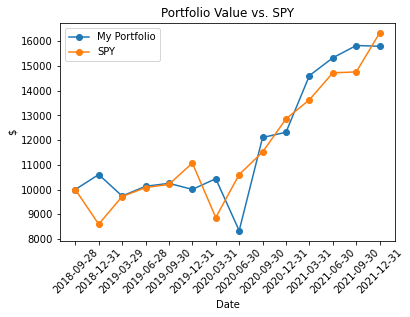

In [140]:
# plot of portfolio totals vs. SPY if buy and hold
plt.plot(SPY_test['Date'], portfolio_value['Total'], '-o', label = 'My Portfolio')
plt.plot(SPY_test['Date'], SPY_test['SPY_Total'], '-o', label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')
plt.xticks(rotation=45)
plt.show()